# TD Deep Q-Network


Hédi Hadiji March 2023  
Adapted from Odalric Ambryn-Maillard

In [1]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import gymnasium as gym
from tqdm import tqdm

import time
import os
from IPython.display import clear_output

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(f"python --version = {sys.version}")
print(f"torch.__version__ = {torch.__version__}")
print(f"np.__version__ = {np.__version__}")
print(f"gym.__version__ = {gym.__version__}")

python --version = 3.9.18 (main, Sep 11 2023, 13:41:44) 
[GCC 11.2.0]
torch.__version__ = 2.3.0+cu121
np.__version__ = 1.22.4
gym.__version__ = 0.29.1


In [4]:
def run_one_episode(env, agent, display=True):
    display_env = deepcopy(env)
    done = False
    state, _ = display_env.reset()

    rewards = 0

    while not done:
        action = agent.get_action(state, 0)
        print(action)
        state, reward, done, _, _ = display_env.step(action)
        rewards += reward
        if display:
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.show()
    if display:
        display_env.close()
    print(f'Episode length {rewards}')

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, terminated, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, terminated, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

# create instance of replay buffer
#replay_buffer = ReplayBuffer(BUFFER_CAPACITY)

In [6]:
class Net(nn.Module):
    """
    Basic neural net.
    """
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x.to(device)).cpu()

In [7]:
class DQN_Skeleton:
    def __init__(self,
                action_space,
                observation_space,
                gamma,
                batch_size,
                buffer_capacity,
                update_target_every,
                epsilon_start,
                decrease_epsilon_factor,
                epsilon_min,
                learning_rate,
                ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma

        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every

        self.epsilon_start = epsilon_start
        self.decrease_epsilon_factor = decrease_epsilon_factor # larger -> more exploration
        self.epsilon_min = epsilon_min

        self.learning_rate = learning_rate

        self.reset()

    def get_action(self, state):
        """
        ** TO BE IMPLEMENTED LATER**

        Return action according to an epsilon-greedy exploration policy
        """
        pass

    def update(self, *data):
        """
        ** TO BE IMPLEMENTED LATER **

        Updates the buffer and the network(s)
        """
        pass

    def get_q(self, state):
        """
        Compute Q function for a states
        """

        state = state.flatten()
        state_tensor = torch.tensor(state).unsqueeze(0)
        with torch.no_grad():
            output = self.q_net.forward(state_tensor) # shape (1,  n_actions)
        return output.numpy()[0]  # shape  (n_actions)

    def decrease_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
                        np.exp(-1. * self.n_eps / self.decrease_epsilon_factor ) )

    def reset(self):
        hidden_size = 256
        obs_size = 1
        for i in range(len(self.observation_space.shape)):
          obs_size *= self.observation_space.shape[i]
        n_actions = self.action_space.n

        self.buffer = ReplayBuffer(self.buffer_capacity)
        self.q_net =  Net(obs_size, hidden_size, n_actions).to(device)
        self.target_net = Net(obs_size, hidden_size, n_actions).to(device)

        self.loss_function = nn.MSELoss()
        self.optimizer = optim.AdamW(params=self.q_net.parameters(), lr=self.learning_rate)

        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0


In [8]:
class RandomAgent:
    def __init__(self, observation_space, action_space):
        self.action_space = action_space
        return

    def get_action(self, state, *args):
        return self.action_space.sample()

    def update(self, *data):
        pass

In [9]:
class DQN_SkeletonI(DQN_Skeleton):
    def get_action(self, state, epsilon=None):
        """
            ** Solution **

            Return action according to an epsilon-greedy exploration policy
        """
        if epsilon is None:
            epsilon = self.epsilon

        if np.random.rand() < epsilon:
            return self.action_space.sample()
        else:
            return np.argmax(self.get_q(state))

In [10]:
def eval_agent(agent, env, n_sim=5):
    """
    ** Solution **

    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done:
            action = agent.get_action(state, 0)
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum
    return episode_rewards

In [11]:
class DQN(DQN_SkeletonI):
    def update(self, state, action, reward, terminated, next_state):
        """
        ** SOLUTION **
        """

        # add data to replay buffer
        self.buffer.push(torch.tensor(state).unsqueeze(0),
                           torch.tensor([[action]], dtype=torch.int64),
                           torch.tensor([reward]),
                           torch.tensor([terminated], dtype=torch.int64),
                           torch.tensor(next_state).unsqueeze(0),
                          )

        if len(self.buffer) < self.batch_size:
            return np.inf

        # get batch
        transitions = self.buffer.sample(self.batch_size)

        # Compute loss - TO BE IMPLEMENTED!
        # Hint: use the gather method from torch.

        state_batch, action_batch, reward_batch, terminated_batch, next_state_batch = tuple(
            [torch.cat(data) for data in zip(*transitions)]
        )
        values  = self.q_net.forward(state_batch).gather(1, action_batch)

        # Compute the ideal Q values
        with torch.no_grad():
            next_state_values = (1 - terminated_batch) * self.target_net(next_state_batch).max(1)[0]
            targets = next_state_values * self.gamma + reward_batch

        loss = self.loss_function(values, targets.unsqueeze(1).type(torch.float32))
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_value_(self.q_net.parameters(), 100)
        self.optimizer.step()

        if not((self.n_steps+1) % self.update_target_every):
            self.target_net.load_state_dict(self.q_net.state_dict())

        self.decrease_epsilon()

        self.n_steps += 1
        if terminated:
            self.n_eps += 1

        return loss.detach().numpy()

In [12]:
env = gym.make("highway-fast-v0", render_mode="rgb_array")

config = {
    "observation": {
        "type": "OccupancyGrid",
        "vehicles_count": 10,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20],
        },
        "grid_size": [[-20, 20], [-20, 20]],
        "grid_step": [5, 5],
        "absolute": False,
        "normalize": True,
    },
    "action": {
        "type": "DiscreteAction",
    },
    "lanes_count": 3,
    "vehicles_count": 10,
    "duration": 20,  # [s]
    "initial_spacing": 0,
    "collision_reward": -1,  # The reward received when colliding with a vehicle.
    "right_lane_reward": 0.5,  # The reward received when driving on the right-most lanes, linearly mapped to
    # zero for other lanes.
    "high_speed_reward": 0.1,  # The reward received when driving at full speed, linearly mapped to zero for
    # lower speeds according to config["reward_speed_range"].
    "lane_change_reward": 0,
    "reward_speed_range": [
        20,
        30,
    ],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD].
    "simulation_frequency": 5,  # [Hz]
    "policy_frequency": 1,  # [Hz]
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "screen_width": 600,  # [px]
    "screen_height": 150,  # [px]
    "centering_position": [0.3, 0.5],
    "scaling": 5.5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False,
    "disable_collision_checks": True,
}

env.unwrapped.configure(config)

In [13]:
def train(env, agent, N_episodes, eval_every=10, reward_threshold=300):
    total_time = 0
    state, _ = env.reset()
    losses = []
    for ep in range(N_episodes):
        done = False
        state, _ = env.reset()
        state = state.flatten()  # Flattening the state at reset for each episode
        while not done:
            action = agent.get_action(state, agent.epsilon)  # Make sure to pass epsilon for exploration
            #,action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = next_state.flatten().astype(np.float32)  # Flattening next_state from the environment
            loss_val = agent.update(state, action, reward, terminated, next_state)
            state = next_state
            losses.append(loss_val)
            done = terminated or truncated
            total_time += 1



        if ((ep+1)% eval_every == 0):
            rewards = eval_agent(agent, env)
            print("episode =", ep+1, ", reward = ", np.mean(rewards), ", loss = ", loss_val)
            if np.mean(rewards) >= reward_threshold:
                break

    return losses

gamma changed 0.6 0.8 0.99

/home/vitoriano/anaconda3/envs/RL/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


episode = 10 , reward =  6.78125 , loss =  0.0880568
episode = 20 , reward =  6.5625 , loss =  0.06831971
episode = 30 , reward =  0.1875 , loss =  0.09202192
episode = 40 , reward =  10.905938185837204 , loss =  0.12087237
episode = 50 , reward =  4.680438164185896 , loss =  0.09699739
episode = 60 , reward =  3.225 , loss =  0.10683595
episode = 70 , reward =  3.6130264730679187 , loss =  0.11833271
episode = 80 , reward =  4.3875 , loss =  0.075116985
episode = 90 , reward =  7.75625 , loss =  0.11502486
episode = 100 , reward =  10.71935 , loss =  0.110110596
episode = 110 , reward =  6.4514 , loss =  0.16083892
episode = 120 , reward =  6.98125 , loss =  0.11974309
episode = 130 , reward =  15.45 , loss =  0.09278284
episode = 140 , reward =  6.76875 , loss =  0.09561393
episode = 150 , reward =  4.44375 , loss =  0.08185652
episode = 160 , reward =  4.863913999999999 , loss =  0.10912801
episode = 170 , reward =  5.8625 , loss =  0.15232553
episode = 180 , reward =  8.169862 , lo

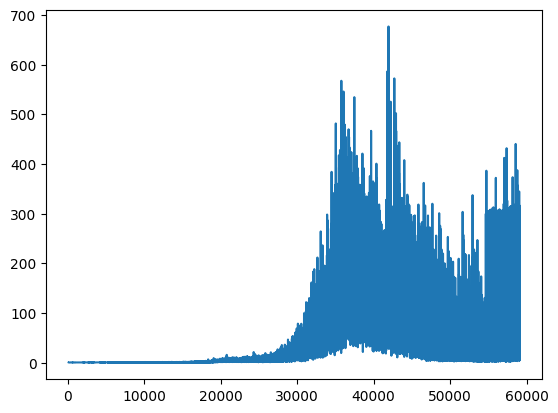

In [15]:
action_space = env.action_space
observation_space = env.observation_space

batch_size = 128
buffer_capacity = 10_000
update_target_every = 32

gamma = 0.99
batch_size = 128
buffer_capacity = 10_000
update_target_every = 512

epsilon_start = 0.99
decrease_epsilon_factor = 1000 # 300
epsilon_min = 0.03

learning_rate = 1e-3 

arguments = (action_space,
            observation_space,
            gamma,
            batch_size,
            buffer_capacity,
            update_target_every,
            epsilon_start,
            decrease_epsilon_factor,
            epsilon_min,
            learning_rate,
        )

N_episodes = int(3e3)

agent = DQN(*arguments)


# Run the training loop
losses = train(env, agent, N_episodes)

plt.plot(losses)

# Evaluate the final policy
rewards = eval_agent(agent, env, 20)
print("")
print("mean reward after training = ", np.mean(rewards))

mean reward after training =  5.3150470515232175  gamma = 0.6 n normalized
mean reward after training =  8.436077401778164 gamma = 0.99 n normalized
mean reward after training =  6.027701038379542 gamma = 0.8 n normalized

mean reward after training =  14.451188498933941 gamma = 0.99 normalized
mean reward after training =  4.447856334147227 gamma = 0.6 normalized
mean reward after training =  3.5761701566076285 gamma = 0.8 normalized




In [16]:
print("Rewards after training = ", eval_agent(agent, env))

Rewards after training =  [18.78125 12.59375 15.6875  15.6875  12.5625 ]


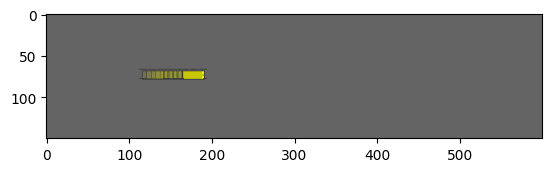

4


AttributeError: 'NoneType' object has no attribute 'get_image'

In [17]:
run_one_episode(env, agent, display=True)

In [18]:
env.close()